## Homework #2
Due 9/26/2024

In [169]:
#IMPORT LIBRARIES
import cv2 #openCV (C++)
import os
import numpy as np
import matplotlib.pyplot as plt

#READ IMAGE
cathedral = cv2.imread(filename=os.path.relpath('Data/Pitt_Cathedral.jpg'),
                       flags=1) #greyscale = 0, color = 1
#FIX COLOR CHANNELS
cathedral = cathedral[:, :, ::-1] #BGR -> RGB

## Problem 1
Define a function to implement the peak-signal-to-noise calculation as described in lecture 4.  

Note: In python functions have the form:

In [170]:
#FUNCTION: findPSNR
def findPSNR(image1, image2):

    #ERROR CHECK
    if image1.shape != image2.shape:
        return
    
    #CONVER DATA TYPES
    image1 = np.float32(image1)
    image2 = np.float32(image2)

    #INITIALIZE VARIABLES
    r, c, d = image1.shape

    MSE = 0

    #CALCULATE MSE
    for color in range(d):
        for i in range(r):
            for j in range(c):
                MSE = MSE + (image1[i, j, color]-image2[i, j, color])**2
    MSE = MSE / np.float32(r * c * d)

    #CALCULATE PSNR
    PSNR = 20*np.log10(np.max(image1)/np.sqrt(MSE))

    return PSNR

## Problem 2
* a) Implement a spatial frequency low-pass filter at 1/3 the Nyquist frequency of the image using a top-hat window (e.g. binary 0/1)
* b) Calculate the peak-SNR comparing the two images
* c) Use any image you like.  Put the image in the data folder for this repo 

PSNR = 3.6056973934173584


Text(0.5, 1.0, 'Filtered Image')

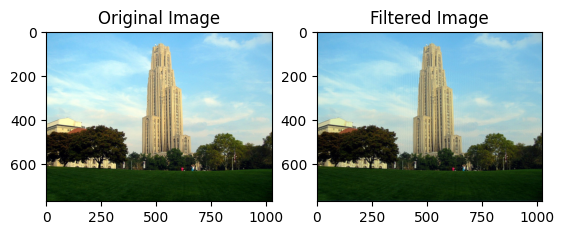

In [171]:
cathedral_lpf = np.zeros(cathedral.shape)

#LOOP THROUGH CHANNEL
for color in range(3):

    #TAKE DFT
    cathedral_dft = cv2.dft(np.float32(cathedral[:, :, color]), flags=cv2.DFT_COMPLEX_OUTPUT)

    #SHIFT ZERO-FREQUENCY TO CENTER
    cathedral_dft = np.fft.fftshift(cathedral_dft)

    #FIND MAGNITUDE AND PHASE
    magnitude = 20*np.log(cv2.magnitude(cathedral_dft[:, :, 0], cathedral_dft[:, :, 1]))
    phase =  np.arctan2(cathedral_dft[:, :, 1], cathedral_dft[:, :, 0])

    x, y = np.indices(magnitude.shape)
    dx = magnitude.shape[0]/2
    dy = magnitude.shape[1]/2
    r = np.sqrt((x-dx)**2+(y-dy)**2)

    #SET fc TO 1/3 THE NYQUIST
    cutoff = (1/3)*np.min([dx, dy])
    LPF_mask = r < cutoff

    #PERFORM FILTER
    cathedral_dft_filtered = np.zeros(cathedral_dft.shape)
    cathedral_dft_filtered[:, :, 0] = cathedral_dft[:, :, 0]*LPF_mask
    cathedral_dft_filtered[:, :, 1] = cathedral_dft[:, :, 1]*LPF_mask
    magnitude_filtered = magnitude*LPF_mask

    #SHIFT BACK
    cathedral_dft_filtered = np.fft.ifftshift(cathedral_dft_filtered)

    #RECOVER IMAGE
    cathedral_filtered = cv2.idft(cathedral_dft_filtered) #inverse DFT
    cathedral_filtered = cv2.magnitude(cathedral_filtered[:, :, 0], cathedral_filtered[:, :, 1]) #find magnitude of complex value

    #INSERT CHANNEL INTO ARRAY
    cathedral_lpf[:, :, color] = cathedral_filtered/np.max(cathedral_filtered)

#FIND PSNR
PSNR = findPSNR(cathedral, cathedral_lpf)
print(f"PSNR = {PSNR}")

#PRINT IMAGES
plt.figure()
plt.subplot(121)
plt.imshow(X=cathedral)
plt.title("Original Image")

plt.subplot(122)
plt.imshow(X=cathedral_lpf)
plt.title("Filtered Image")

## Problem 3
Implement a similar low-pass filter as problem 2 (1/3 the Nyquist) in the spatial domain as a kernel convolution (e.g. using the sinc function definitions in lecture 5).  Use a top-hat window (e.g. without worrying about tapering the edges).  Use the same image you used in problem 2. 

PSNR = 8.462227821350098


Text(0.5, 1.0, 'LPF Center Channel')

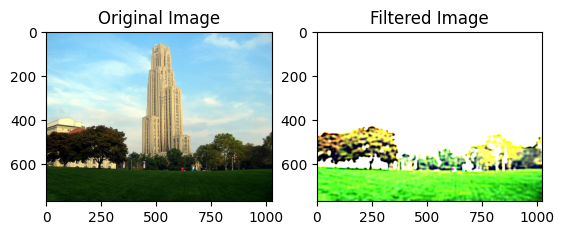

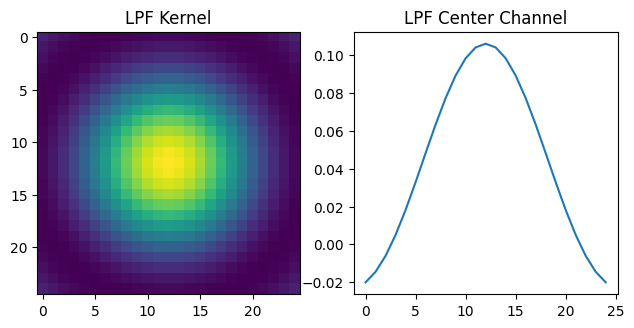

In [172]:
#LPF KERNEL
x, y = np.indices([25,25])  #25x25 kernel
x = x-12; y = y-12; #make x[12, :] = y[:, 12] = 0
r = np.sqrt(x**2+y**2) #calculate r
r[12, 12] = 1 #ensure r is not 0 (temporary)

fc = 1/3 #set cutoff frequency to 1/3 the Nyquist frequency
LPF_kernel = np.sin(r*fc)/(np.pi*r) #calculate LPF kernel
LPF_kernel[12,12]=fc/np.pi #replace point where r was 0

#WINDOWED LPF KERNEL
# LPF_kernel_windowed = LPF_kernel*np.outer(np.hanning(25), np.hanning(25))

#PASS IMAGE THROUGH FILTER
cathedral_lpf = cv2.filter2D(src=cathedral, ddepth=-1, kernel=LPF_kernel)

#FIND PSNR
PSNR = findPSNR(cathedral, cathedral_lpf)
print(f"PSNR = {PSNR}")

#PRINT IMAGES
plt.figure()
plt.subplot(121)
plt.imshow(X=cathedral)
plt.title("Original Image")

plt.subplot(122)
plt.imshow(X=cathedral_lpf)
plt.title("Filtered Image")

#PRINT FILTERS
plt.figure(figsize=[7.5, 7.5])
plt.subplot(221)
plt.imshow(LPF_kernel)
plt.title("LPF Kernel") 
plt.subplot(222)
plt.plot(LPF_kernel[:, 12])
plt.title("LPF Center Channel") 

# plt.subplot(223)
# plt.imshow(LPF_kernel_windowed)
# plt.title("Windowed LPF Kernel") 
# plt.subplot(224)
# plt.plot(LPF_kernel_windowed[:,12])
# plt.title("Windowed LPF Center Channel") 

## Problem 4
Define a function to implement a mean smoothing kernel filter.  

[ECE1390]
* As an input to your function, allow the user to select between a arithmatic, geometric, or harmonic mean
* Assume a fixed 3x3 binary morphological kernel 

[ECE 2690]
* As an input to your function, allow the user to select between a arithmatic, geometric, harmonic mean, or contraharmonic mean ("m" should be an input parameter)
* Design your function to allow any arbitary binary morphological kernel 

Text(0.5, 1.0, 'Harmonic Mean Smoothing')

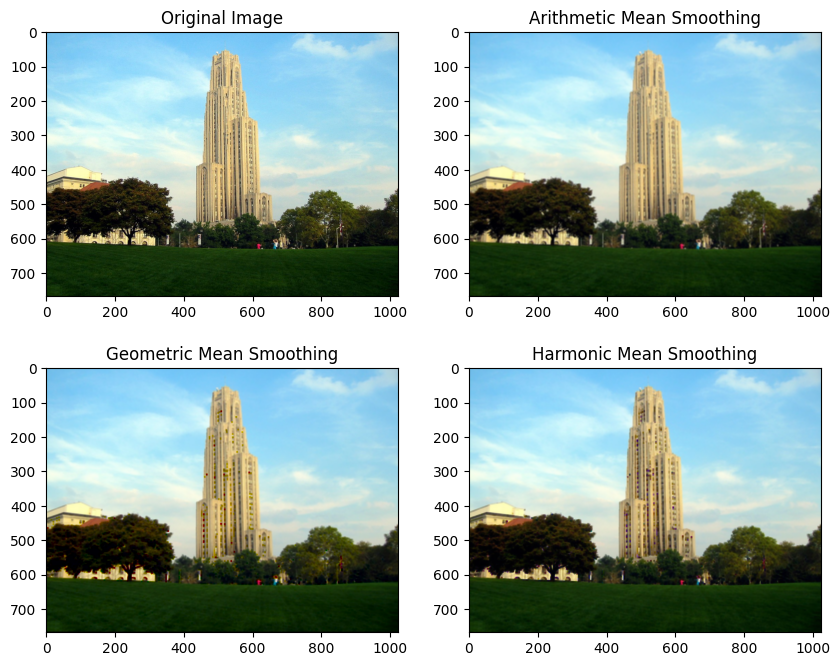

In [ ]:
#FUNCTION: findMean
def findMean(kernel, type):

    #CONVERT DATATYPE
    kernel = np.float64(kernel) #convert kernel to float

    #ARITHMETIC MEAN
    if type == "arithmetic":
        m = 0
        n = np.float64(kernel.shape[0]*kernel.shape[1])
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                m = m + kernel[i, j]
        m = m/n
    
    #GEOMETRIC MEAN
    elif type == "geometric":
        m = 1
        n = np.float64(kernel.shape[0]*kernel.shape[1])
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                m = m * kernel[i, j]
        m = m**(1/n)

    #HARMONIC MEAN
    elif type == "harmonic":
        m = 0
        n = 0
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                if kernel[i, j]: #prevent division by zero
                    m = m + (1/kernel[i, j])
                    n = n + 1 #only count elements used
        if m:
            m = n/m
        
    return m

#FUNCTION: meanSmoothing
def meanSmoothing(image, kernel, type):
    
    #CHECK KERNEL DIMENSIONS
    if (kernel[0]%2 == 0) or (kernel[0]%2 == 0):
        print("Kernel must have an odd number of rows and columns. No median filter applied.")
        return
    
    #CHECK MEAN TYPE
    if type != "arithmetic" and type != "geometric" and type != "harmonic":
        print("Select a valid mean type: arithmetic, geometric, or harmonic.")
        return

    #INITALIZE KERNEL
    h, w = kernel
    kernel_values = np.zeros(shape=(h, w, image.shape[2])) #depth of kernel = depth of image
    
    #ZERO PAD IMAGE
    top = bottom = np.int32(np.floor(h/2)) #half the kernel height
    left = right = np.int32(np.floor(w/2)) #half the kernel width
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    r1, c1, d1 = image.shape #new dimensions
    image_smoothed = image.copy() #preserve original image during replacement

    #LOOP THROUGH EACH ANCHOR
    for i in range(r1-h): #i = image row index
        for j in range(c1-w): #j = image column index

            #DEFINE THE CURRENT KERNEL
            for k in range(h): #k = kernel row index
                for l in range(w): #l = kernel column index
                    kernel_values[k, l, :] = image[i+k, j+l, :]

            #FIND MEAN ACCORDING TO SELECTED TYPE
            image_smoothed[i+top, j+bottom, 0] = findMean(kernel_values[:, :, 0], type)
            image_smoothed[i+top, j+bottom, 1] = findMean(kernel_values[:, :, 1], type)
            image_smoothed[i+top, j+bottom, 2] = findMean(kernel_values[:, :, 2], type)

    #REMOVE ZERO PADDING
    image_smoothed = image_smoothed[top:r1-bottom, left:c1-right, :]
    return image_smoothed

#TEST EACH MEAN
cathedral_arithmetic = meanSmoothing(image=cathedral, kernel=(5, 5), type="arithmetic")
cathedral_geometric = meanSmoothing(image=cathedral, kernel=(5, 5), type="geometric")
cathedral_harmonic = meanSmoothing(image=cathedral, kernel=(5, 5), type="harmonic")

#PRINT IMAGES
plt.figure(figsize=[10, 8])

plt.subplot(221)
plt.imshow(X=cathedral)
plt.title("Original Image")

plt.subplot(222)
plt.imshow(X=cathedral_arithmetic)
plt.title("Arithmetic Mean Smoothing")

plt.subplot(223)
plt.imshow(X=cathedral_geometric)
plt.title("Geometric Mean Smoothing")

plt.subplot(224)
plt.imshow(X=cathedral_harmonic)
plt.title("Harmonic Mean Smoothing")


## Problem 5 [ECE 2390 only]
Define a function to compute the discrete cosine transform of an image.  Include code to pad the image appropriately. The equation for the DCT was given in lecture 4  